# Fully-saturated TWFE

In [2]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns
import pymc as pm
import arviz as az
az.style.use('arviz-darkgrid')

rng = np.random.default_rng(42)
figsize = (10, 5)

In [10]:
filepath = '../../data/processed/df_filtered.xlsx'
df = pd.read_excel(filepath)

df.island_ids = df.island_ids.astype(str)
df.island_ids = df.island_ids.map(str.strip)
island_id, mn_island_ids = df.island_ids.factorize()

df.bridge_year = df.bridge_year.astype(str)
df.bridge_year = df.bridge_year.map(str.strip)
bridge_year, mn_bridge_years = df.bridge_year.factorize()

df.time_since_treatment = df.time_since_treatment.astype(str)
df.time_since_treatment = df.time_since_treatment.map(str.strip)
time_since_treatment, mn_time_since_treatments = df.time_since_treatment.factorize()


$$
\begin{aligned}
\log{Y^{**}_{it}} &\sim \mathcal{t} (\nu, \mu_{it}, \sigma_i^2) \\
\nu &\sim \text{Exponential}(1/10) \\
\mu_{it} &= \alpha + \beta_{gl} \cdot T_{i} \\
\alpha &\sim \mathcal{N}(0, 0.1^2) \\
\beta_{gl} &\sim \mathcal{N}(\mu_{\beta}, \sigma_{\beta}^2) \\
\sigma_i &\sim \mathcal{C}^+(\sigma_0^2) \\
\end{aligned}
$$

- $\beta_{gl}$: 介入時期 $g$ と介入経過時間 $l$ によって変動する介入効果
- $T_{it}$: 介入群ダミー
- $\mu_{\beta} \sim N(0, 0.3^2)$: 介入時期と介入経過時間の期待値を表すハイパーパラメータ
- $\sigma_{\beta}^2 \sim N^+(0.3^2)$: 介入時期と介入経過時間の分散を表すハイパーパラメータ
- $\sigma_0^2 \sim N^+(0.24^2)$: 島間の誤差分散を表すハイパーパラメータ
- $\sigma_i^2$: 島間の誤差分散

## 階層ベイズモデル 不均一分散

/home/keisei/data-analysis/.venv/lib/python3.12/site-packages/pymc/model/core.py:1302: ImputationWarning: Data in y_obs contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)


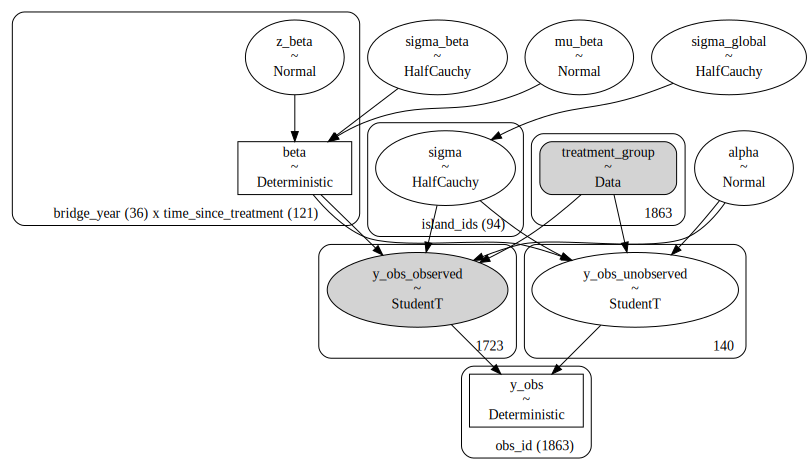

In [4]:
COORDS = {
    'obs_id': df.index,
    'island_ids': mn_island_ids,
    'bridge_year': mn_bridge_years,
    'time_since_treatment': mn_time_since_treatments,
}

with pm.Model(coords=COORDS) as model_h_hetero:
    # data
    # island_ids = pm.Data('island_ids', island_ids)
    # bridge_year = pm.Data('bridge_year', bridge_year)
    treatment_group = pm.Data('treatment_group', df['treatment_group'])
    # time_since_treatment = pm.Data('time_since_treatment', time_since_treatment)

    # priors
    # ATT
    mu_beta = pm.Normal('mu_beta', mu=0, sigma=0.1)
    sigma_beta = pm.HalfCauchy('sigma_beta', 0.1)
    z_beta = pm.Normal('z_beta', mu=0, sigma=1, dims=('bridge_year', 'time_since_treatment'))
    beta = pm.Deterministic('beta', mu_beta + sigma_beta * z_beta, dims=('bridge_year', 'time_since_treatment'))

    # sigma
    sigma_global = pm.HalfCauchy('sigma_global', 0.15)
    sigma = pm.HalfCauchy('sigma', sigma_global, dims='island_ids')

    # fixed effects
    alpha = pm.Normal('alpha', mu=0, sigma=0.1)
    nu = 7

    # expected value
    mu = alpha + beta[bridge_year, time_since_treatment] * treatment_group

    # likelihood
    y_obs = pm.StudentT('y_obs', mu=mu, sigma=sigma[island_id], nu=nu, observed=df['log_pop_star'], dims='obs_id')

pm.model_to_graphviz(model_h_hetero)

In [5]:
with model_h_hetero:
    trace_h_hetero = pm.sample(
        draws=2500,
        tune=1000,
        chains=4,
        cores=4,
        nuts_sampler='numpyro',
        random_seed=rng,
        target_accept=0.95, # これを設定しないとチェーンが動かない
    )

  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [6]:
trace_h_hetero = az.from_netcdf('./mcmc_sample/fully_saturated/hie_hetero_const_20250108.nc')

In [1]:
# サンプリングの保存
az.to_netcdf(trace_h_hetero, './mcmc_sample/fully_saturated/hie_hetero_const_20250108.nc')

NameError: name 'az' is not defined

In [7]:
az.summary(trace_h_hetero, var_names=['alpha', 'mu_beta', 'sigma_beta', 'sigma_global',], hdi_prob=0.95)

mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
alpha         0.024  0.004     0.017      0.031      0.000      0.0     340.0   
mu_beta      -0.055  0.009    -0.072     -0.038      0.000      0.0     366.0   
sigma_beta    0.123  0.007     0.110      0.139      0.001      0.0     128.0   
sigma_global  0.135  0.017     0.104      0.171      0.001      0.0     760.0   

              ess_tail  r_hat  
alpha            469.0   1.02  
mu_beta         1046.0   1.11  
sigma_beta       137.0   1.05  
sigma_global    2742.0   1.06

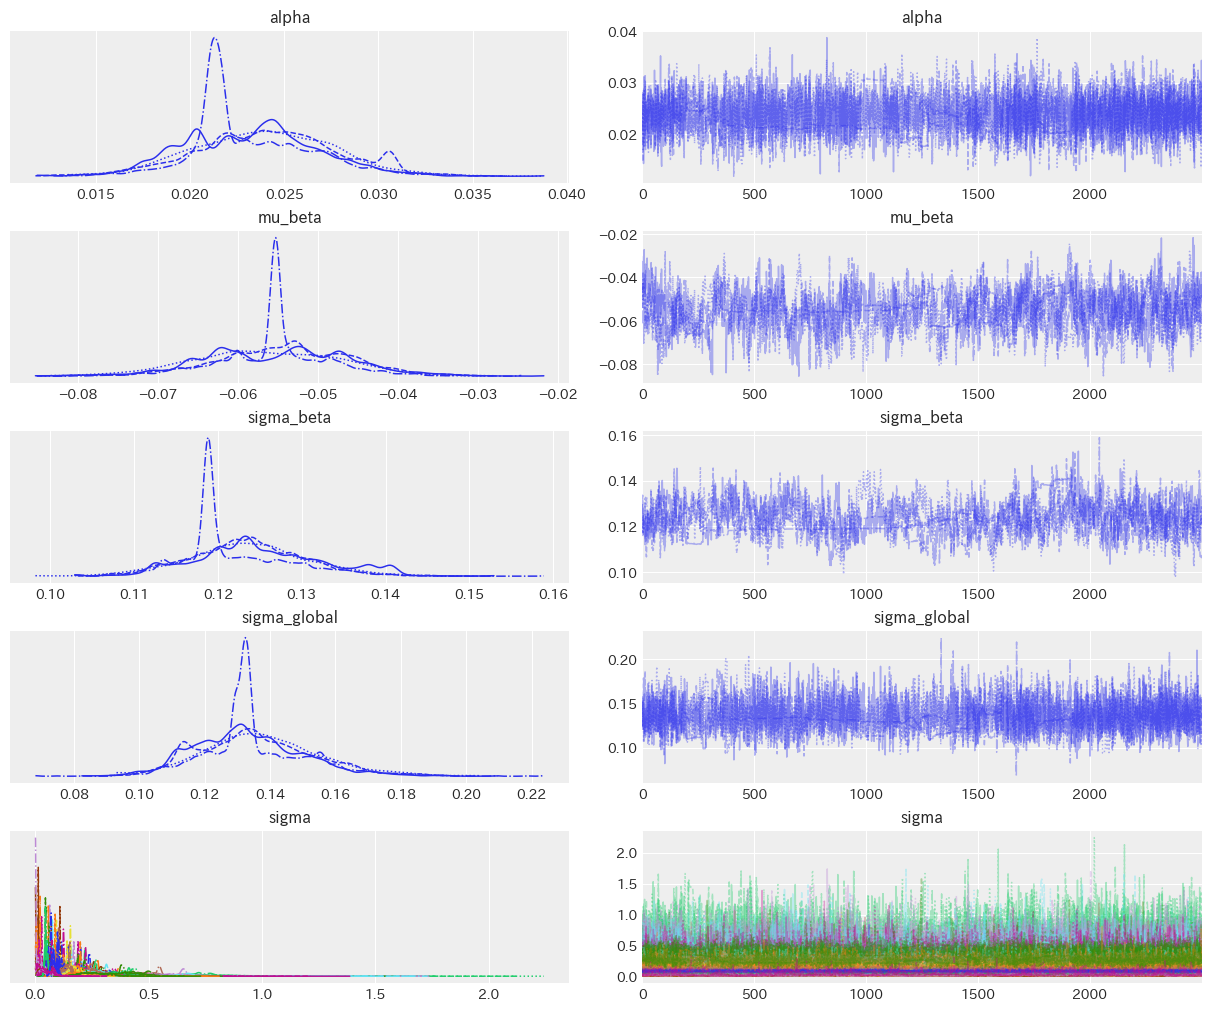

In [8]:
az.plot_trace(trace_h_hetero, var_names=['alpha', 'mu_beta', 'sigma_beta', 'sigma_global', 'sigma']);

In [13]:
beta_df = az.summary(trace_h_hetero, var_names=['beta'], hdi_prob=0.95)

In [15]:
# 正規表現でbridge_yearとtime_since_treatmentを抽出
pattern = r'beta\[(\d+),\s*(-?\d+)\]'
extracted = beta_df.index.str.extract(pattern)
extracted.index = beta_df.index
beta_df['bridge_year'] = extracted[0].astype(int)
beta_df['time_since_treatment'] = extracted[1].astype(int)


In [18]:
beta_df.to_csv('../../data/processed/fully_saturated/hetero_const.csv', index=True)

In [19]:
beta_df.r_hat.max()

1.18

## 階層ベイズモデル 均一分散

/home/keisei/data-analysis/.venv/lib/python3.12/site-packages/pymc/model/core.py:1302: ImputationWarning: Data in y_obs contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)


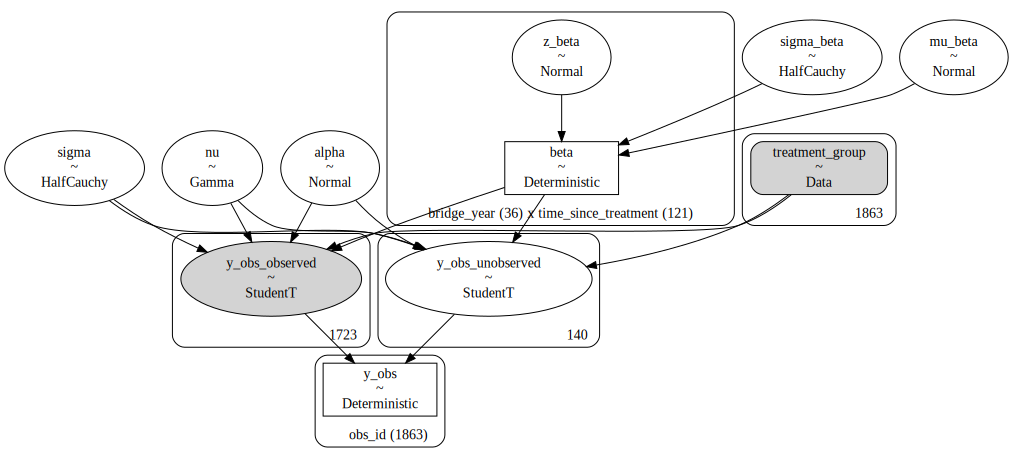

In [41]:
COORDS = {
    'obs_id': df.index,
    'island_ids': mn_island_ids,
    'bridge_year': mn_bridge_years,
    'time_since_treatment': mn_time_since_treatments,
}

with pm.Model(coords=COORDS) as model_h_homo:
    # data
    # island_ids = pm.Data('island_ids', island_id)
    # bridge_year = pm.Data('bridge_year', bridge_year)
    treatment_group = pm.Data('treatment_group', df['treatment_group'])
    # time_since_treatment = pm.Data('time_since_treatment', time_since_treatment)

    # priors
    # ATT
    mu_beta = pm.Normal('mu_beta', mu=0, sigma=1)
    sigma_beta = pm.HalfCauchy('sigma_beta', 1)
    z_beta = pm.Normal('z_beta', mu=0, sigma=1, dims=('bridge_year', 'time_since_treatment'))
    beta = pm.Deterministic('beta', mu_beta + sigma_beta * z_beta, dims=('bridge_year', 'time_since_treatment'))

    # sigma
    sigma = pm.HalfCauchy('sigma', 0.15) # log_pop_star の標準偏差

    # fixed effects
    alpha = pm.Normal('alpha', mu=0, sigma=1)
    nu = pm.Gamma('nu', alpha=2, beta=0.1)

    # expected value
    mu = alpha + beta[bridge_year, time_since_treatment] * treatment_group

    # likelihood
    y_obs = pm.StudentT('y_obs', mu=mu, sigma=sigma, nu=nu, observed=df['log_pop_star'], dims='obs_id')

pm.model_to_graphviz(model_h_homo)

In [42]:
with model_h_homo:
    trace_h_homo = pm.sample(
        draws=1500,
        tune=1000,
        chains=4,
        cores=4,
        nuts_sampler='numpyro',
        random_seed=rng,
    )

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

In [43]:
az.to_netcdf(trace_h_homo, './mcmc_sample/fully_saturated/homo.nc')

'./mcmc_sample/fully_saturated/homo.nc'

In [44]:
az.summary(trace_h_homo, var_names=['alpha', 'mu_beta', 'sigma_beta', 'sigma', 'nu'], hdi_prob=.95)

mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
alpha       0.016  0.005     0.007      0.026      0.000    0.000    8411.0   
mu_beta    -0.062  0.010    -0.081     -0.043      0.000    0.000    3386.0   
sigma_beta  0.111  0.011     0.090      0.131      0.000    0.000    1213.0   
sigma       0.126  0.005     0.116      0.136      0.000    0.000    2049.0   
nu          2.447  0.196     2.086      2.840      0.004    0.003    2582.0   

            ess_tail  r_hat  
alpha         4435.0    1.0  
mu_beta       3835.0    1.0  
sigma_beta    2507.0    1.0  
sigma         3598.0    1.0  
nu            3873.0    1.0

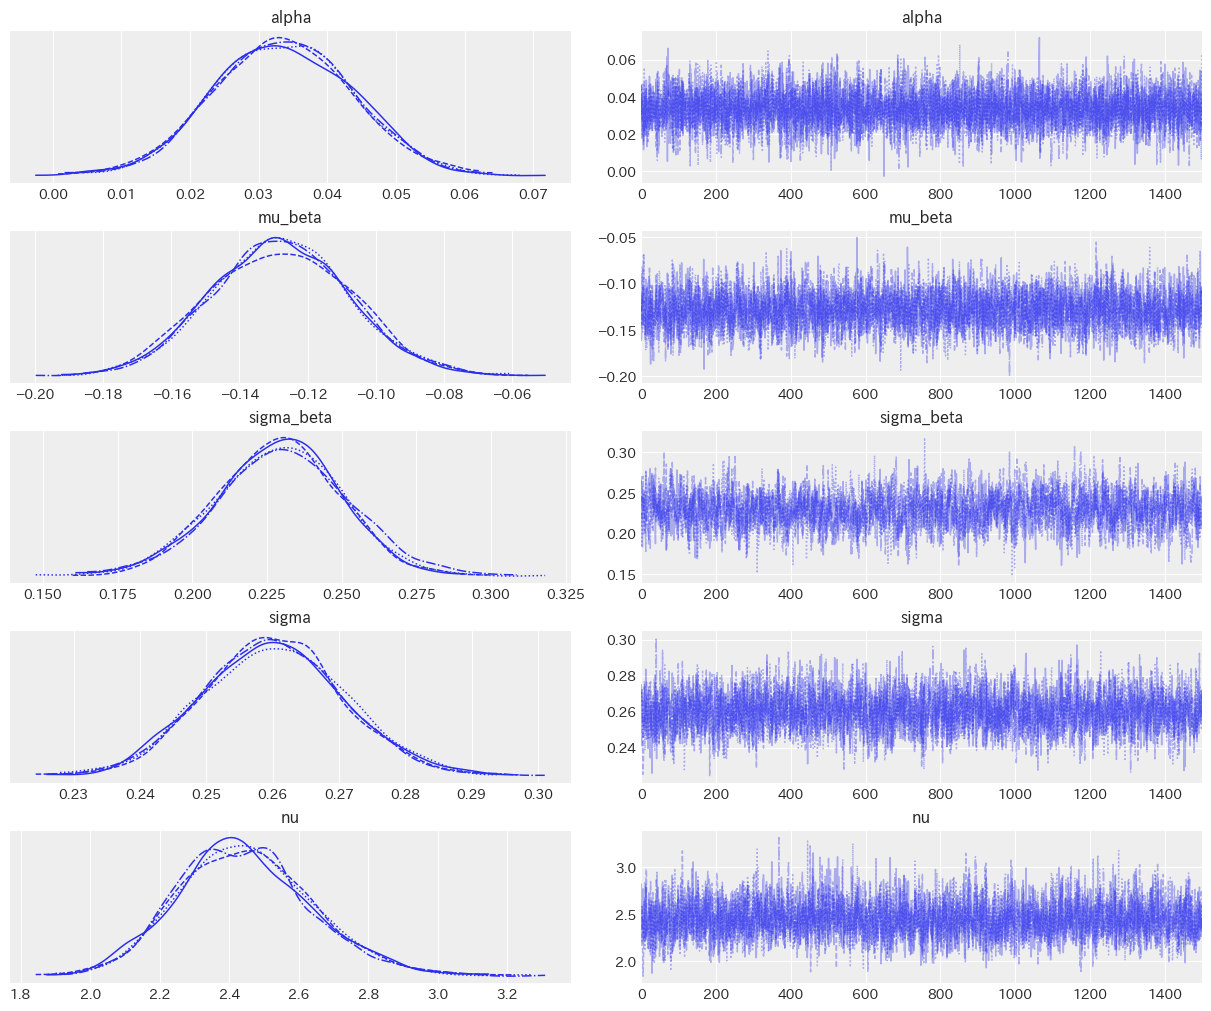

In [12]:
az.plot_trace(trace_h_homo, var_names=['alpha', 'mu_beta', 'sigma_beta', 'sigma', 'nu']);

In [7]:
with model_h_homo:
    pm.compute_log_likelihood(trace_h_homo)

Output()

In [8]:
az.waic(trace_h_homo)

/home/keisei/data-analysis/.venv/lib/python3.12/site-packages/arviz/stats/stats.py:1653: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Computed from 6000 posterior samples and 1723 observations log-likelihood matrix.

          Estimate       SE
elpd_waic   256.83    45.88
p_waic      181.55        -

There has been a warning during the calculation. Please check the results.

In [13]:
with model_h_homo:
    pm.sample_posterior_predictive(trace_h_homo, extend_inferencedata=True)

Sampling: [y_obs_observed]


Output()

In [24]:
y_pred = trace_h_homo.posterior_predictive.y_obs.mean(['chain', 'draw'])
residuals = log_pop_star_scaled - y_pred

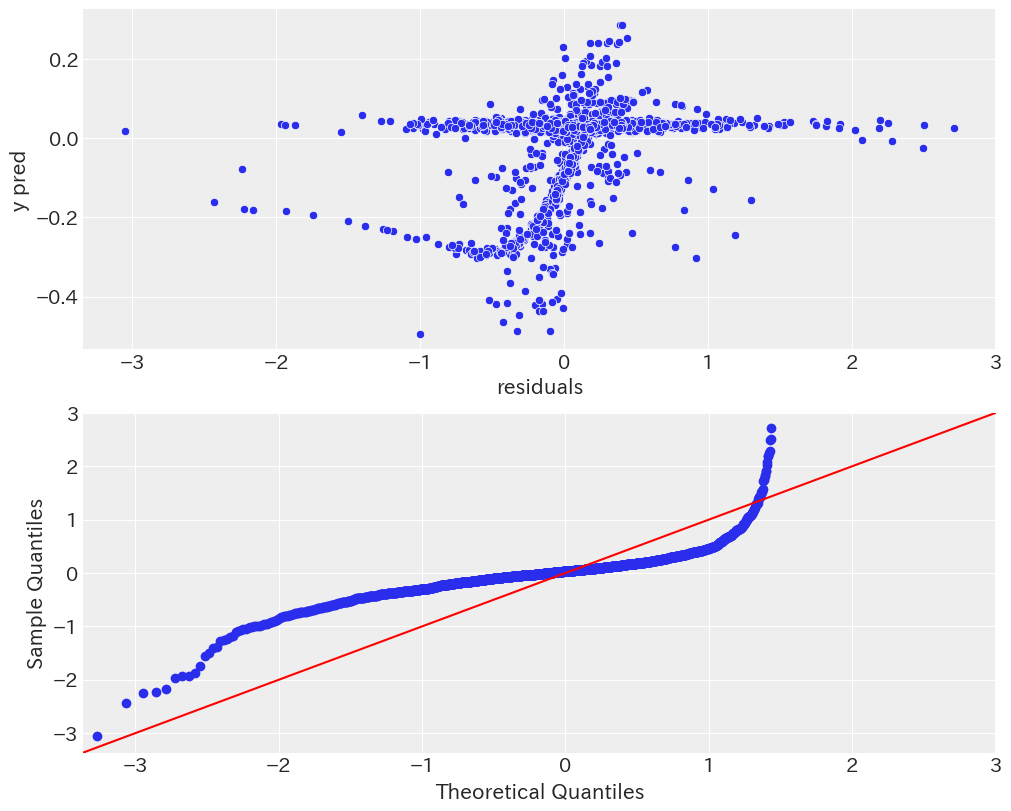

In [34]:
import statsmodels.api as sm

fig, ax = plt.subplots(2, 1, figsize=(10, 8))

sns.scatterplot(x=residuals, y=y_pred, ax=ax[0])
ax[0].set_xlabel('residuals')
ax[0].set_ylabel('y pred')

sm.qqplot(residuals, line='45', ax=ax[1])

plt.show()

betaのr-hatは最大で1.01なので良し．

In [45]:
beta_df = az.summary(trace_h_homo, var_names=['beta'], hdi_prob=.95)
beta_df.head()

mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  \
beta[1999, -29] -0.035  0.086    -0.202      0.130      0.001    0.001   
beta[1999, -24]  0.018  0.098    -0.170      0.211      0.001    0.001   
beta[1999, -19] -0.045  0.086    -0.215      0.126      0.001    0.001   
beta[1999, -14] -0.063  0.086    -0.230      0.112      0.001    0.001   
beta[1999, -9]  -0.071  0.084    -0.243      0.083      0.001    0.001   

                 ess_bulk  ess_tail  r_hat  
beta[1999, -29]    7110.0    4521.0    1.0  
beta[1999, -24]    7292.0    4541.0    1.0  
beta[1999, -19]    6423.0    4114.0    1.0  
beta[1999, -14]    6264.0    3849.0    1.0  
beta[1999, -9]     8096.0    4471.0    1.0

In [100]:
pattern = r'beta\[(\d+),\s*(-?\d+)\]'
extracted = beta_df.index.str.extract(pattern)
extracted.index = beta_df.index
beta_df['bridge_year'] = extracted[0].astype(int)
beta_df['time_since_treatment'] = extracted[1].astype(int)


## 階層ベイズモデル 均一分散 ラッソ

/home/keisei/data-analysis/.venv/lib/python3.12/site-packages/pymc/model/core.py:1302: ImputationWarning: Data in y_obs contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)


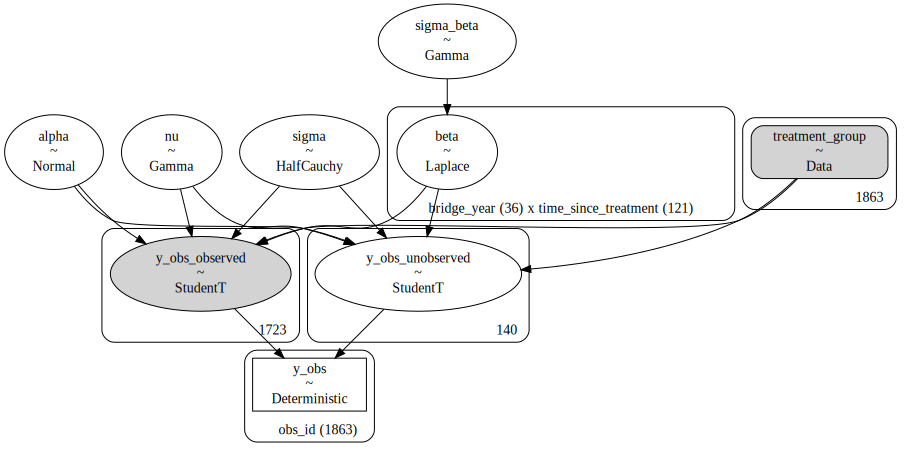

In [3]:
COORDS = {
    'obs_id': df.index,
    'island_ids': mn_island_ids,
    'bridge_year': mn_bridge_years,
    'time_since_treatment': mn_time_since_treatments,
}

with pm.Model(coords=COORDS) as model_h_homo_lasso:
    # data
    # island_ids = pm.Data('island_ids', island_id)
    # bridge_year = pm.Data('bridge_year', bridge_year)
    treatment_group = pm.Data('treatment_group', df['treatment_group'])
    # time_since_treatment = pm.Data('time_since_treatment', time_since_treatment)

    # priors
    # ATT
    # mu_beta = pm.Normal('mu_beta', mu=0, sigma=1)
    sigma_beta = pm.Gamma('sigma_beta', alpha=1, beta=1)
    beta = pm.Laplace('beta', mu=0, b=sigma_beta, dims=('bridge_year', 'time_since_treatment'))

    # sigma
    sigma = pm.HalfCauchy('sigma', 0.15) # log_pop_star の標準偏差

    # fixed effects
    alpha = pm.Normal('alpha', mu=0, sigma=1)
    nu = pm.Gamma('nu', alpha=2, beta=0.1)

    # expected value
    mu = alpha + beta[bridge_year, time_since_treatment] * treatment_group

    # likelihood
    y_obs = pm.StudentT('y_obs', mu=mu, sigma=sigma, nu=nu, observed=df['log_pop_star'], dims='obs_id')

pm.model_to_graphviz(model_h_homo_lasso)

In [113]:
with model_h_homo_lasso:
    trace_h_homo_lasso = pm.sample(
        draws=2000,
        tune=1000,
        chains=4,
        cores=4,
        nuts_sampler='numpyro',
        random_seed=rng
    )

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [114]:
# az.to_netcdf(trace_h_homo_lasso, './mcmc_sample/fully_saturated/hie_homo_lasso.nc')

'./mcmc_sample/fully_saturated/hie_homo_lasso.nc'

In [4]:
trace_h_homo_lasso = az.from_netcdf('./mcmc_sample/fully_saturated/hie_homo_lasso.nc')

In [7]:
az.summary(trace_h_homo_lasso, var_names=['alpha', 'sigma_beta', 'nu', 'sigma'], hdi_prob=.95)

mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
alpha       0.002  0.004    -0.006      0.011      0.000    0.000    6232.0   
sigma_beta  0.085  0.010     0.067      0.105      0.001    0.001      46.0   
nu          2.471  0.197     2.096      2.861      0.004    0.003    2252.0   
sigma       0.128  0.005     0.118      0.138      0.000    0.000     477.0   

            ess_tail  r_hat  
alpha         6755.0   1.00  
sigma_beta     131.0   1.08  
nu            5263.0   1.00  
sigma         1788.0   1.01

array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>],
       [<Axes: title={'center': 'sigma_beta'}>,
        <Axes: title={'center': 'sigma_beta'}>],
       [<Axes: title={'center': 'nu'}>, <Axes: title={'center': 'nu'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

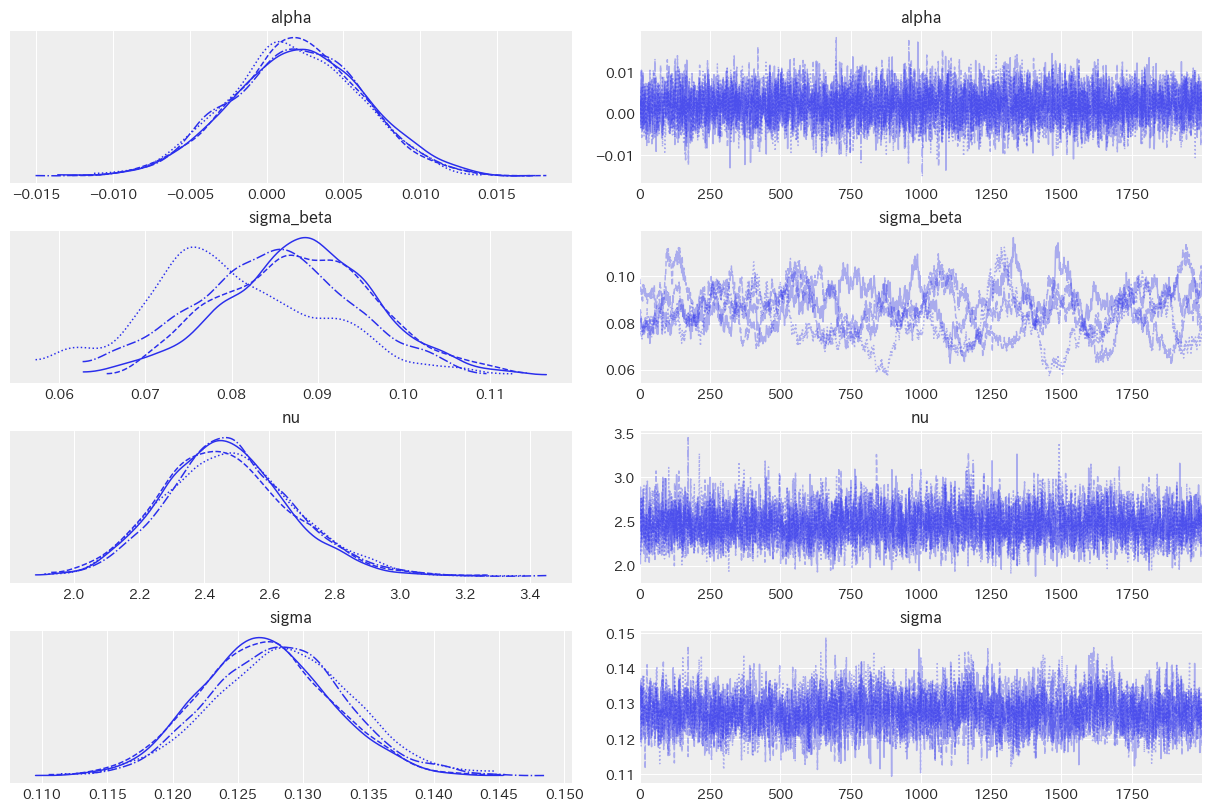

In [8]:
az.plot_trace(trace_h_homo_lasso, var_names=['alpha', 'sigma_beta', 'nu', 'sigma']);

In [5]:
beta_df = az.summary(trace_h_homo_lasso, var_names=['z_beta'], hdi_prob=.95)

In [6]:
beta_df['r_hat'].max()

1.01

In [7]:
pattern = r'beta\[(\d+),\s*(-?\d+)\]'
extracted = beta_df.index.str.extract(pattern)
extracted.index = beta_df.index
beta_df['bridge_year'] = extracted[0].astype(int)
beta_df['time_since_treatment'] = extracted[1].astype(int)
beta_df.head()

mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  \
z_beta[1999, -29]  0.006  0.078    -0.148      0.171      0.001    0.001   
z_beta[1999, -24]  0.057  0.096    -0.118      0.260      0.001    0.001   
z_beta[1999, -19] -0.003  0.075    -0.160      0.150      0.001    0.001   
z_beta[1999, -14] -0.016  0.077    -0.186      0.129      0.001    0.001   
z_beta[1999, -9]  -0.022  0.081    -0.185      0.149      0.001    0.001   

                   ess_bulk  ess_tail  r_hat  bridge_year  \
z_beta[1999, -29]    8643.0    4246.0    1.0         1999   
z_beta[1999, -24]    9346.0    4455.0    1.0         1999   
z_beta[1999, -19]    8926.0    4343.0    1.0         1999   
z_beta[1999, -14]    9581.0    4568.0    1.0         1999   
z_beta[1999, -9]     8572.0    4498.0    1.0         1999   

                   time_since_treatment  
z_beta[1999, -29]                   -29  
z_beta[1999, -24]                   -24  
z_beta[1999, -19]                   -19  
z_beta[1999, -14]                   -14  
z_beta[1999, -9]                     -9

<Axes: xlabel='time_since_treatment', ylabel='mean'>

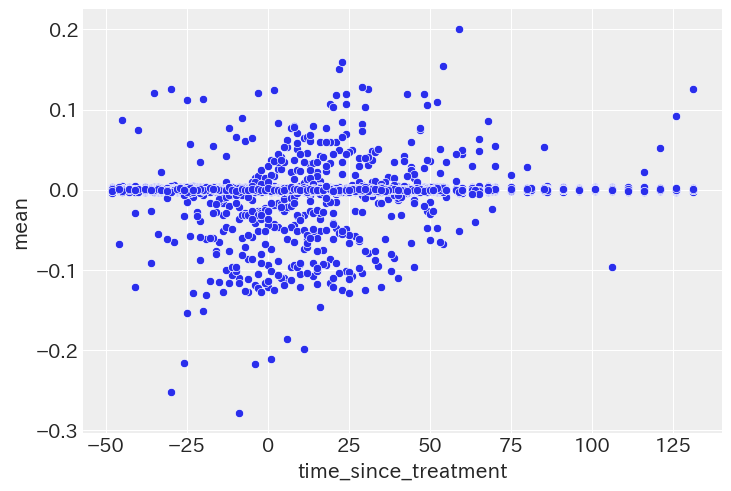

In [10]:
# fig, ax = plt.subplot)
sns.scatterplot(x='time_since_treatment', y='mean', data=beta_df)

/tmp/ipykernel_73269/3187594851.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=figsize)


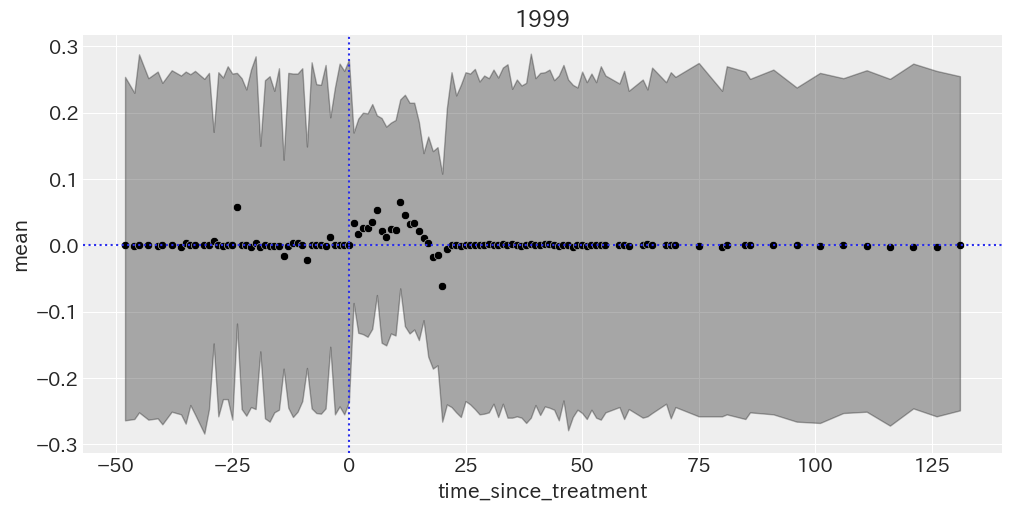

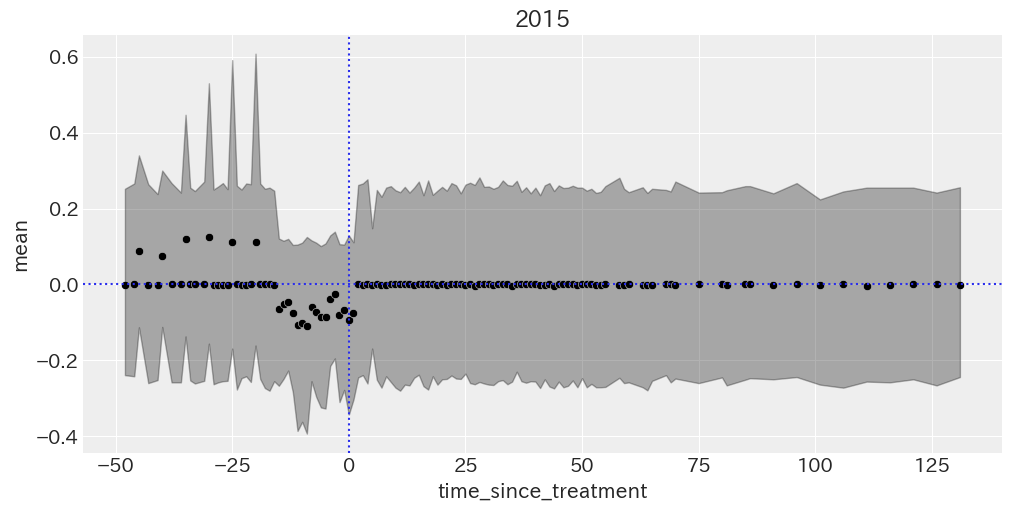

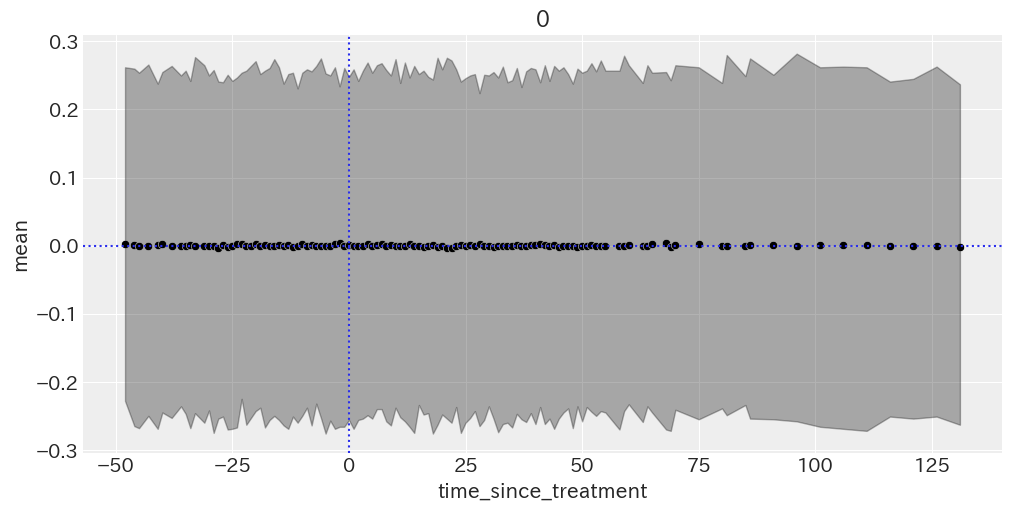

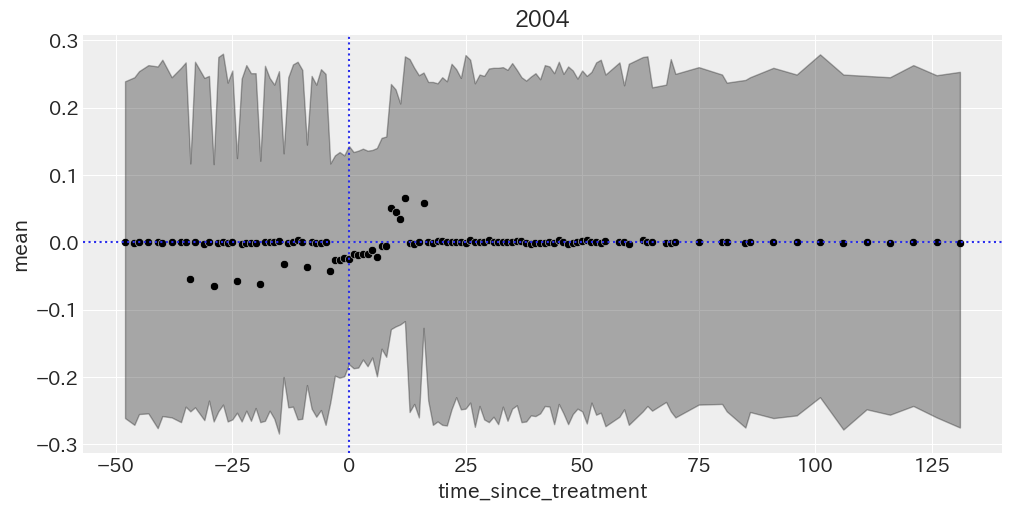

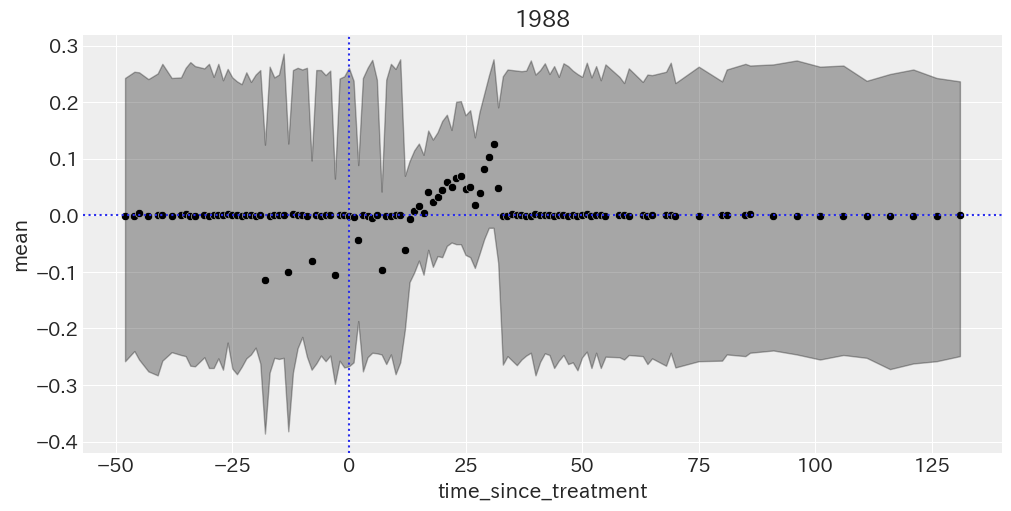

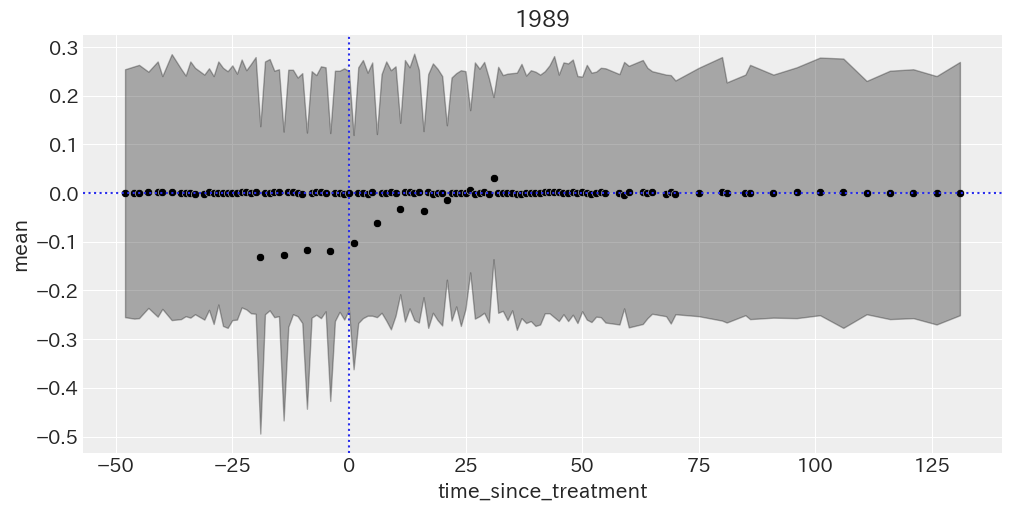

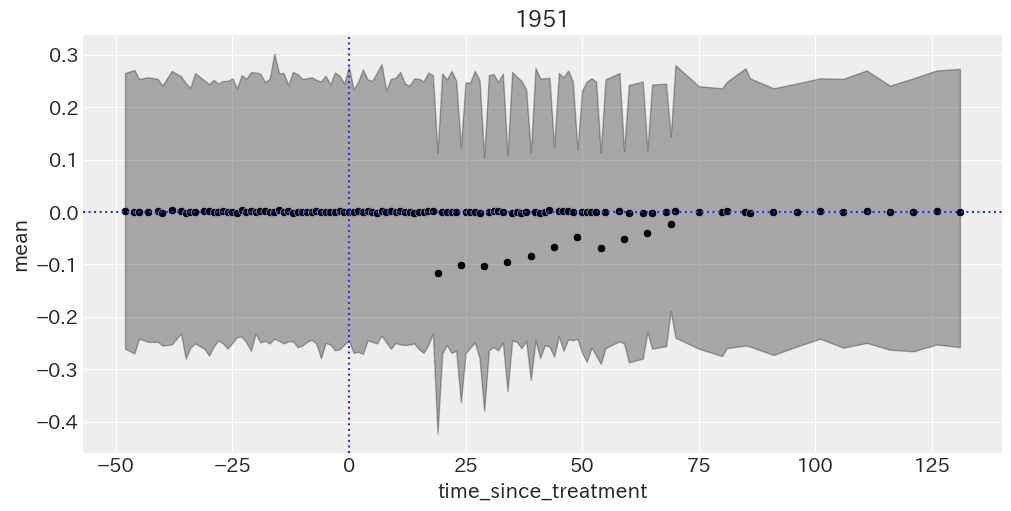

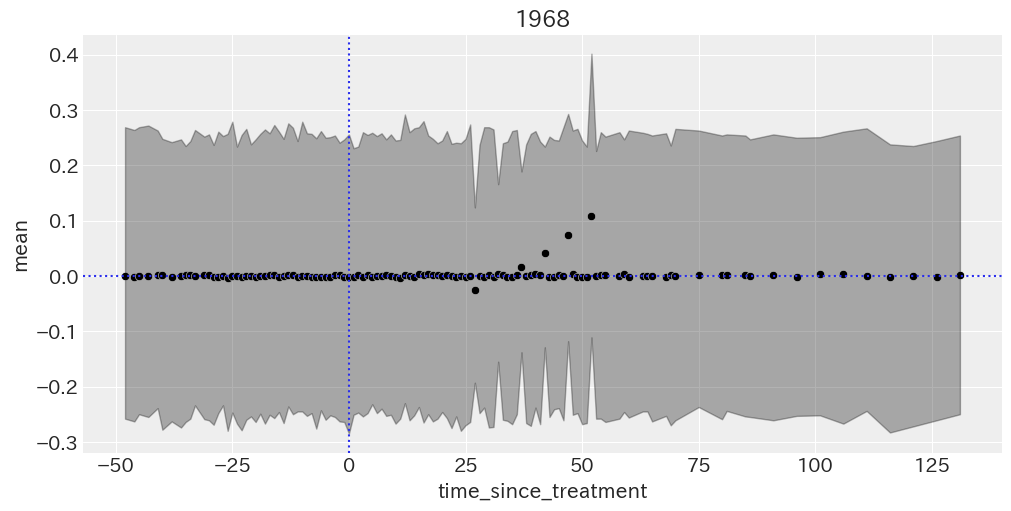

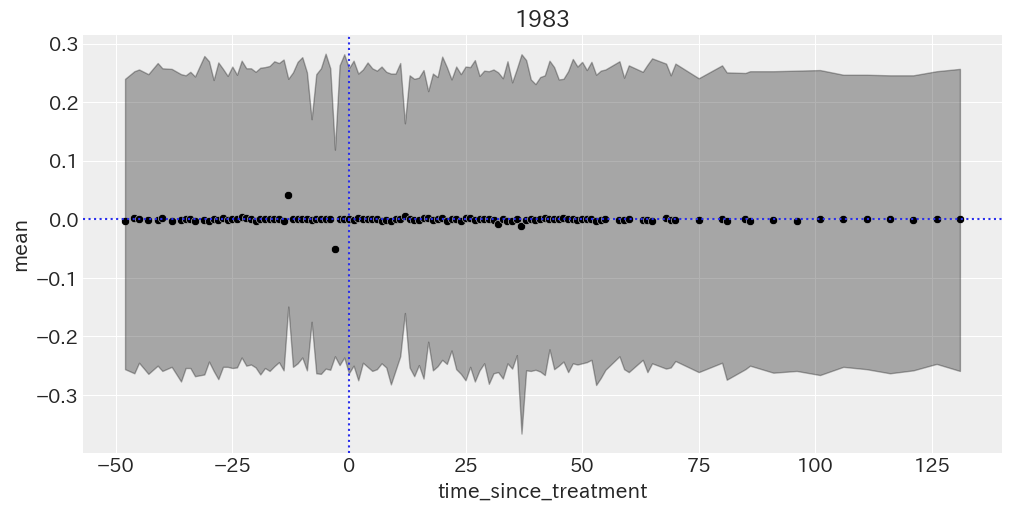

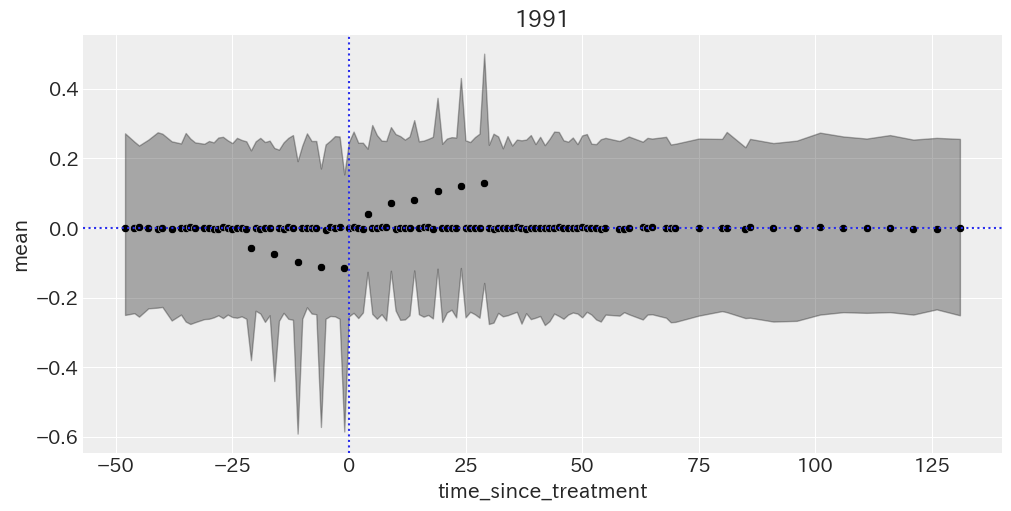

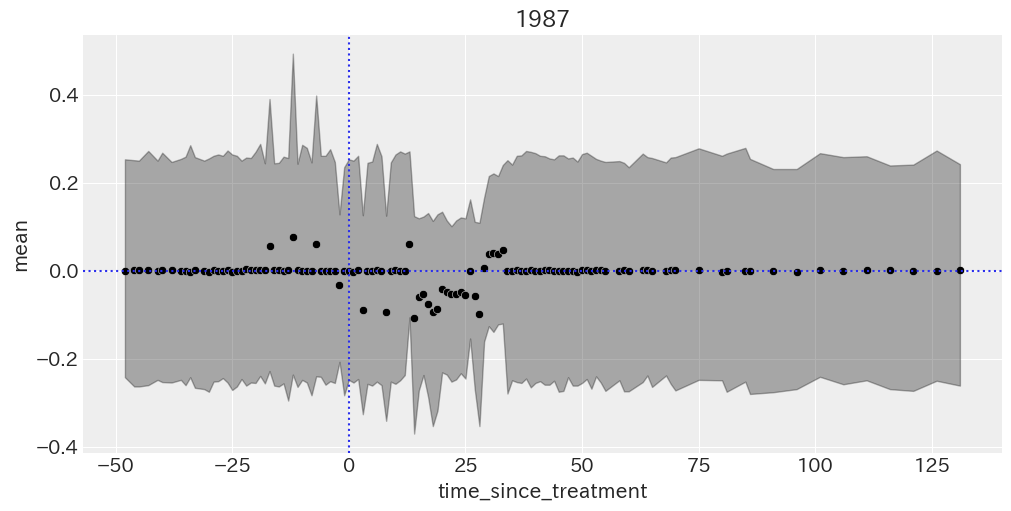

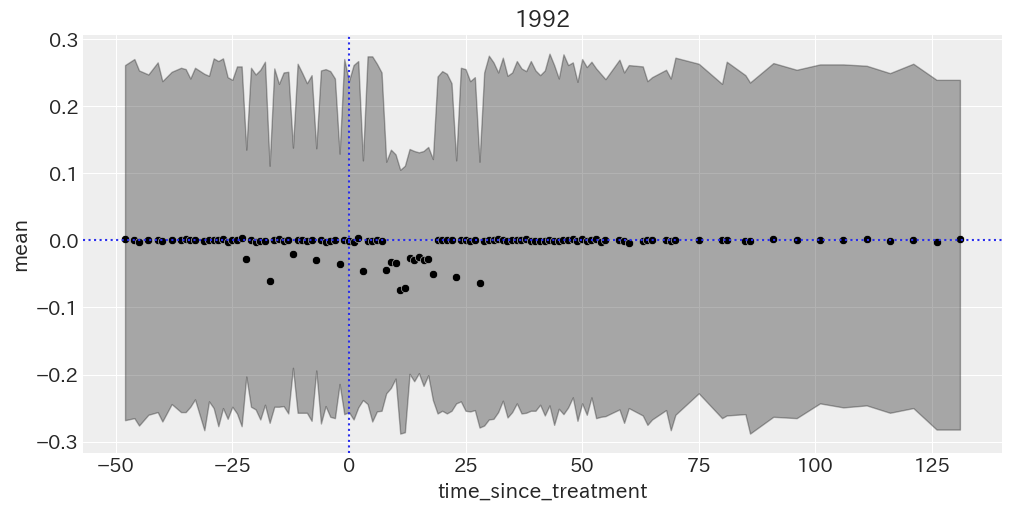

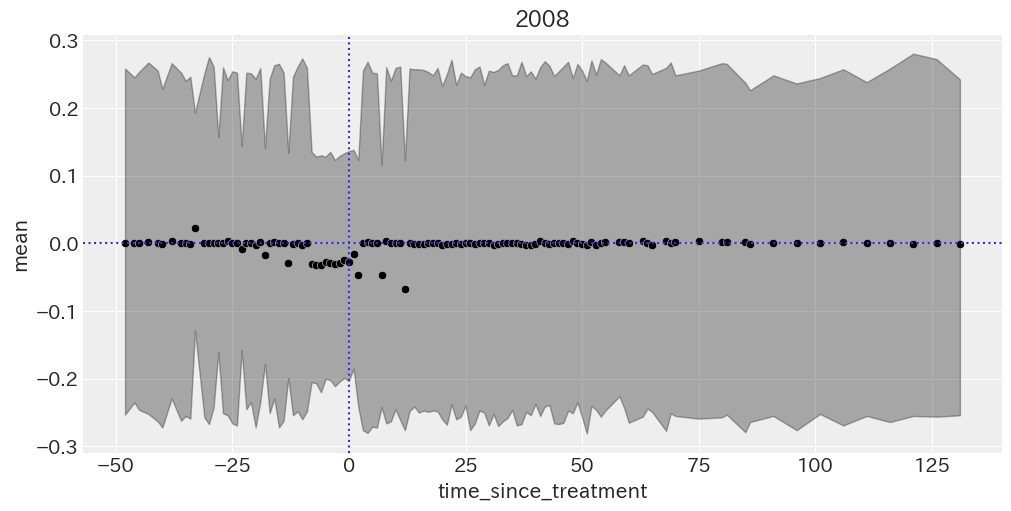

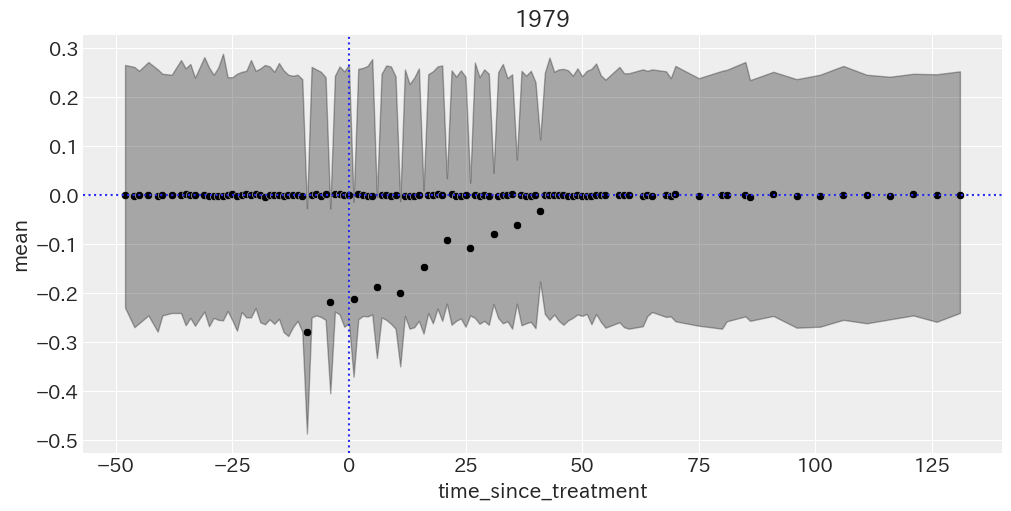

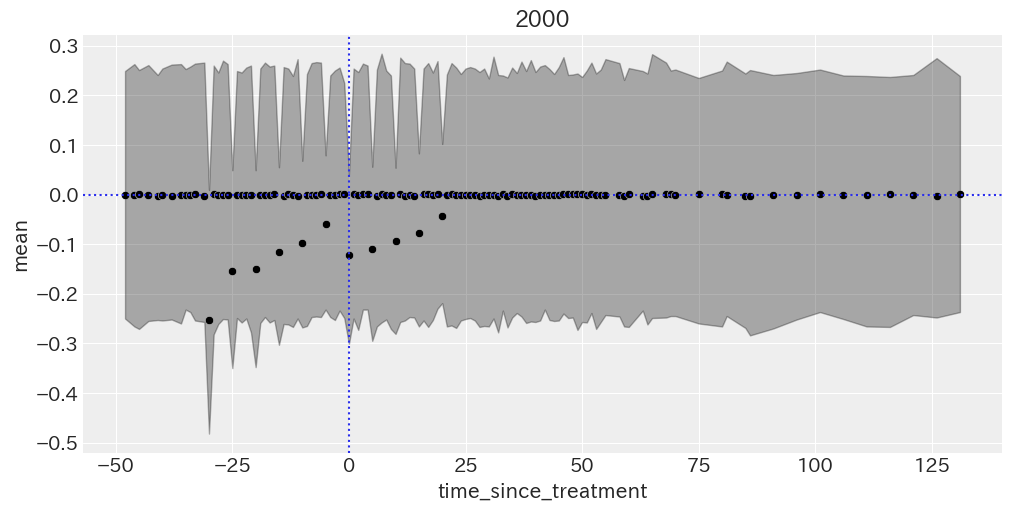

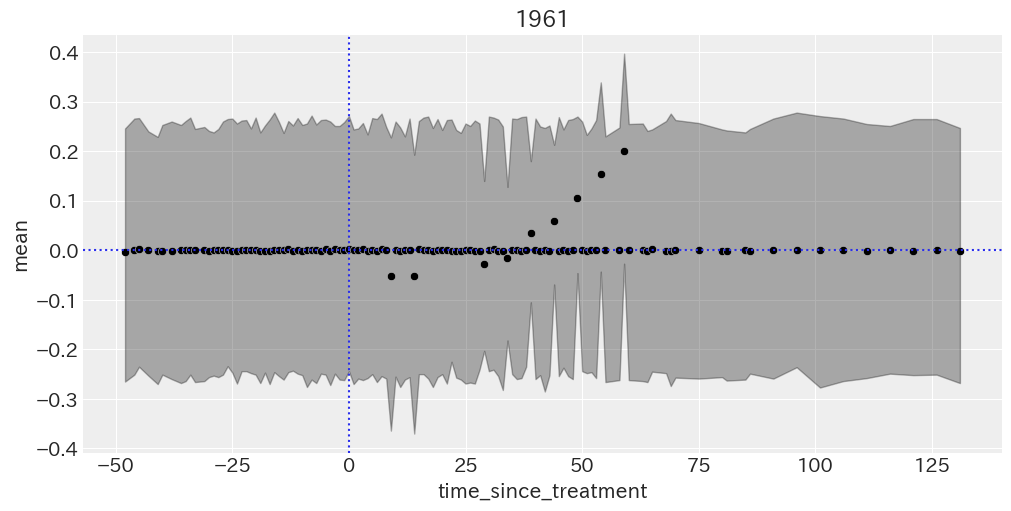

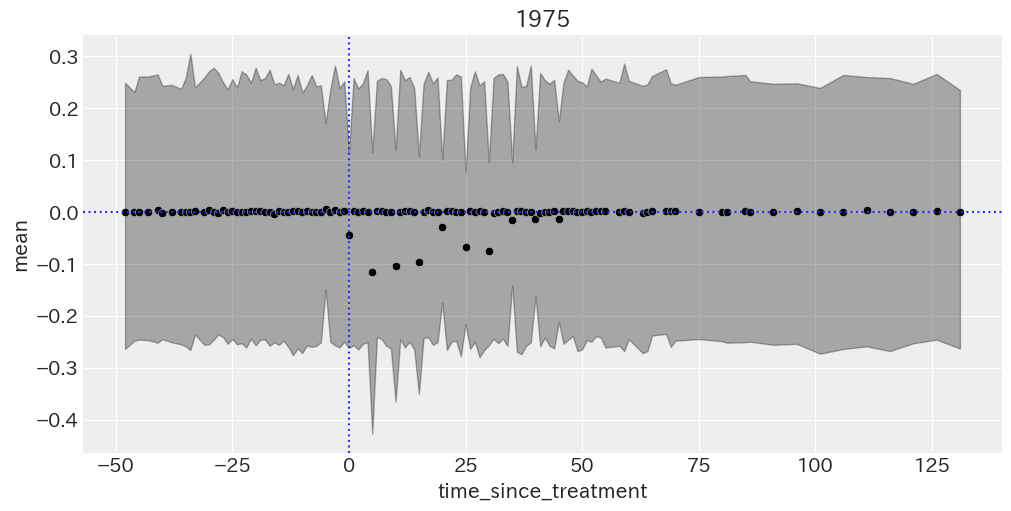

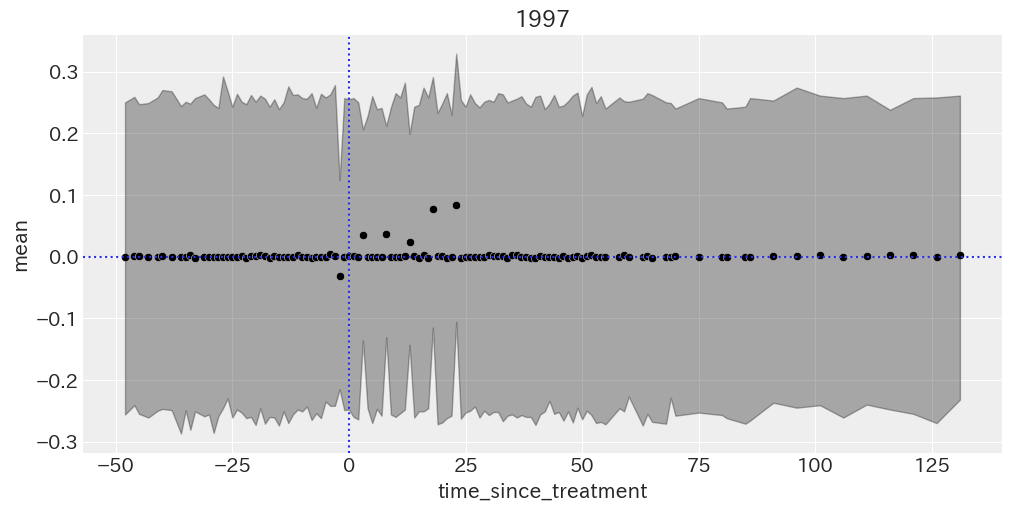

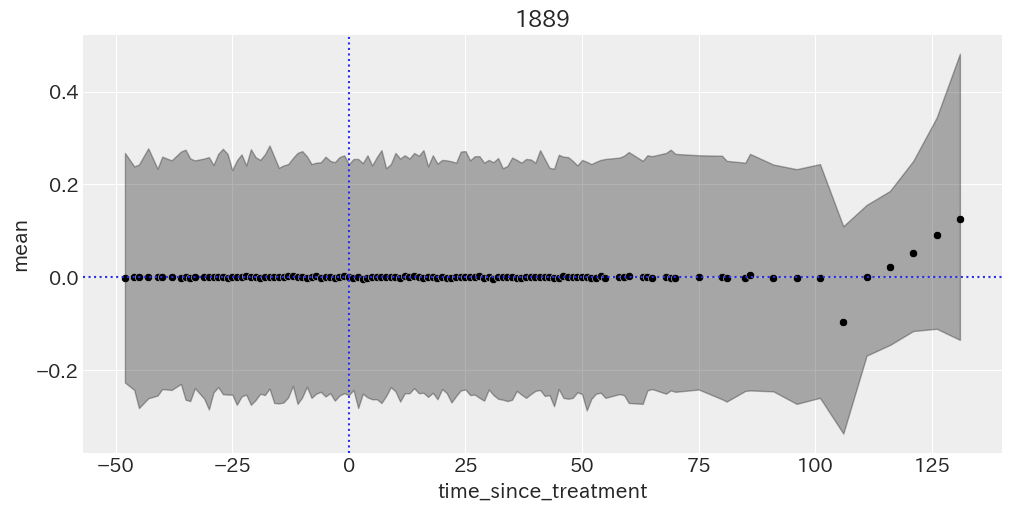

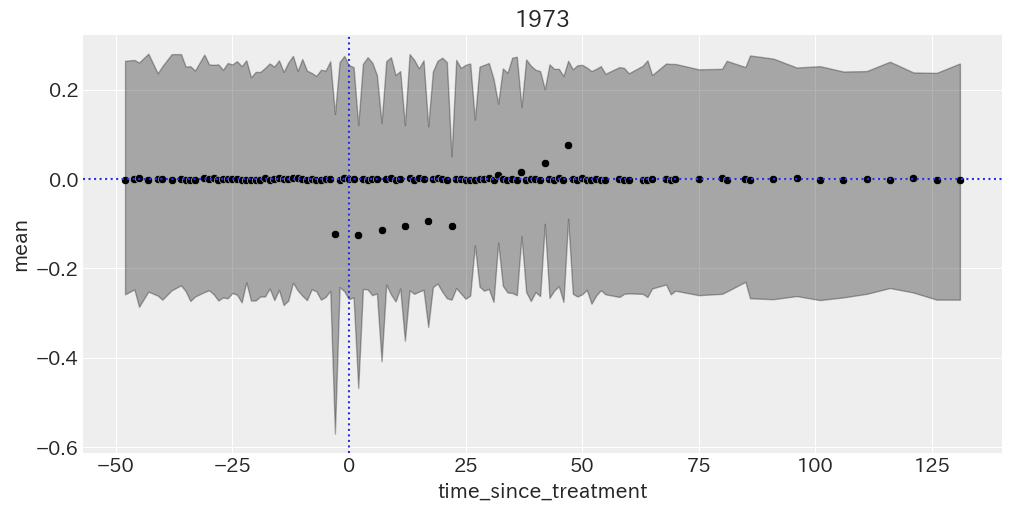

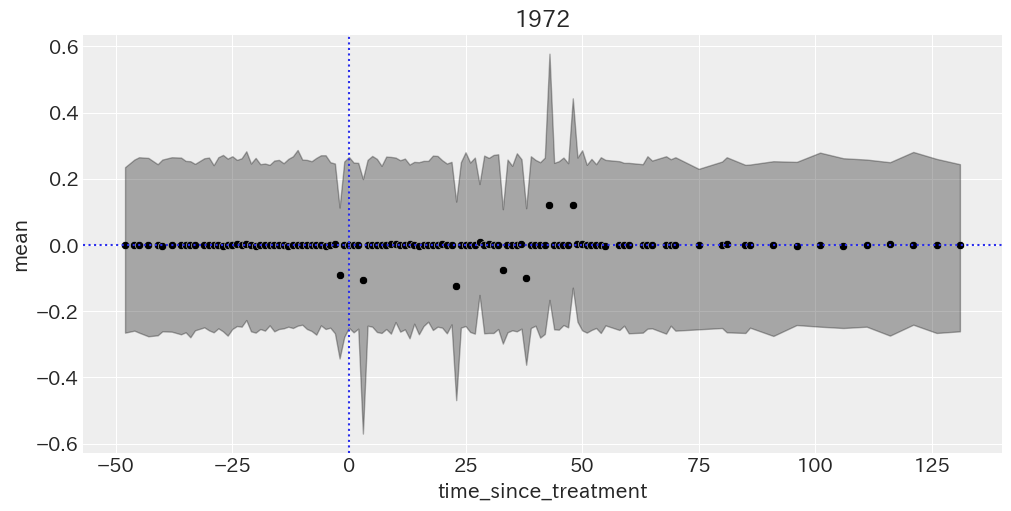

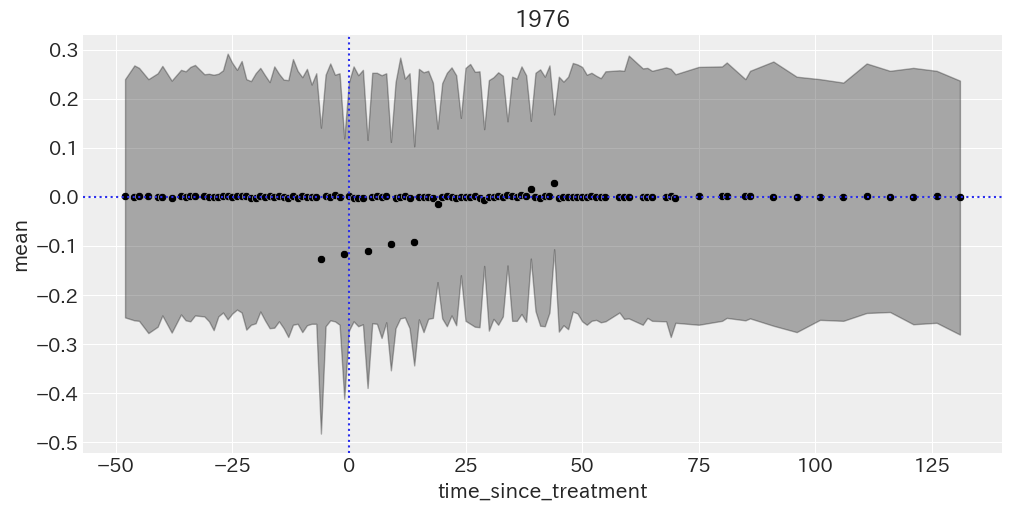

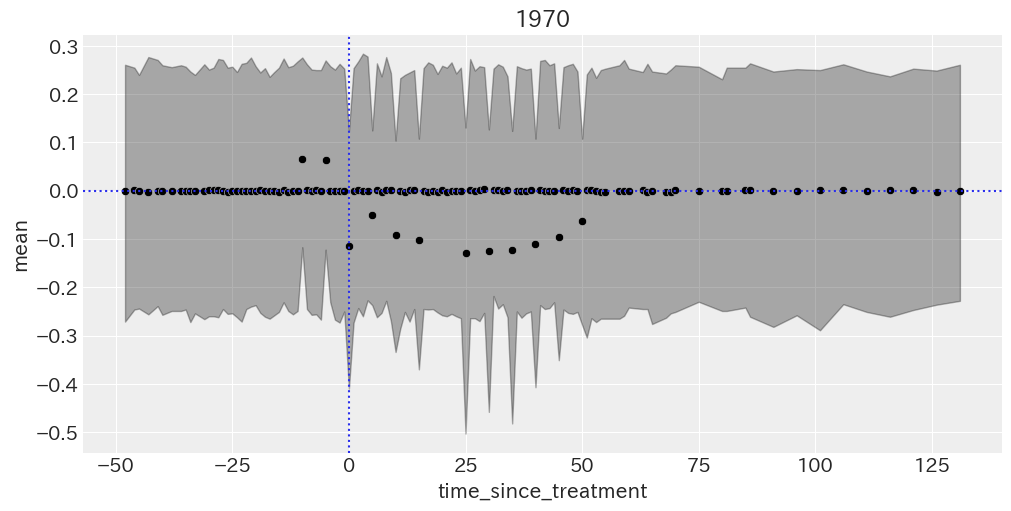

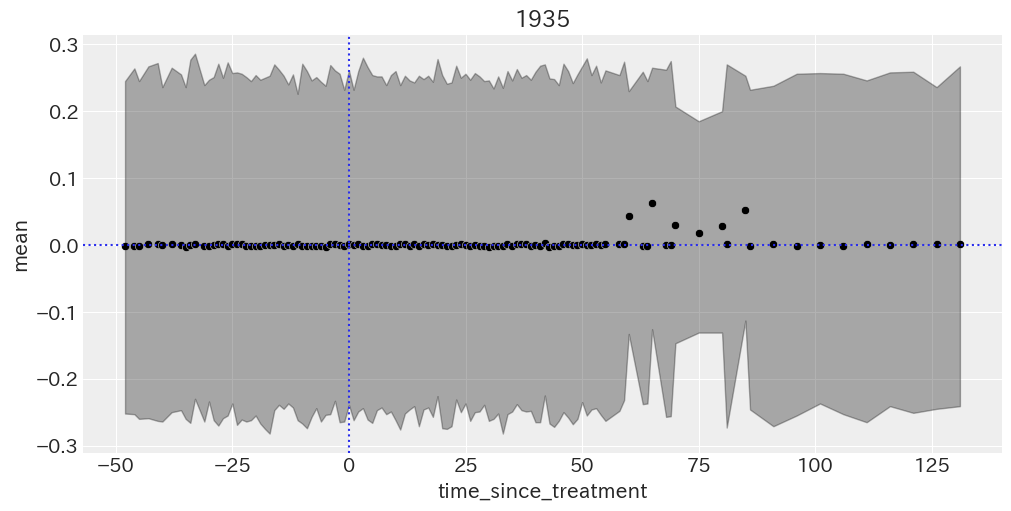

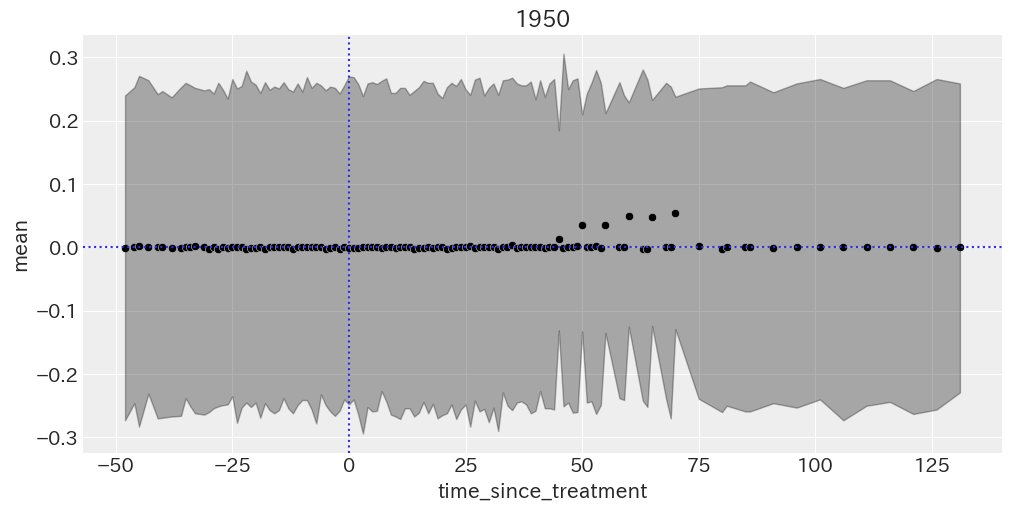

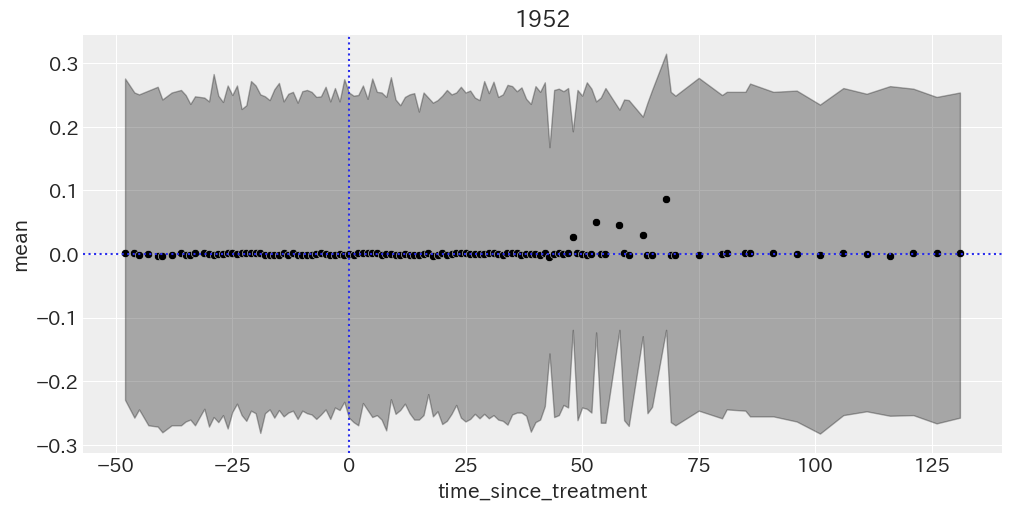

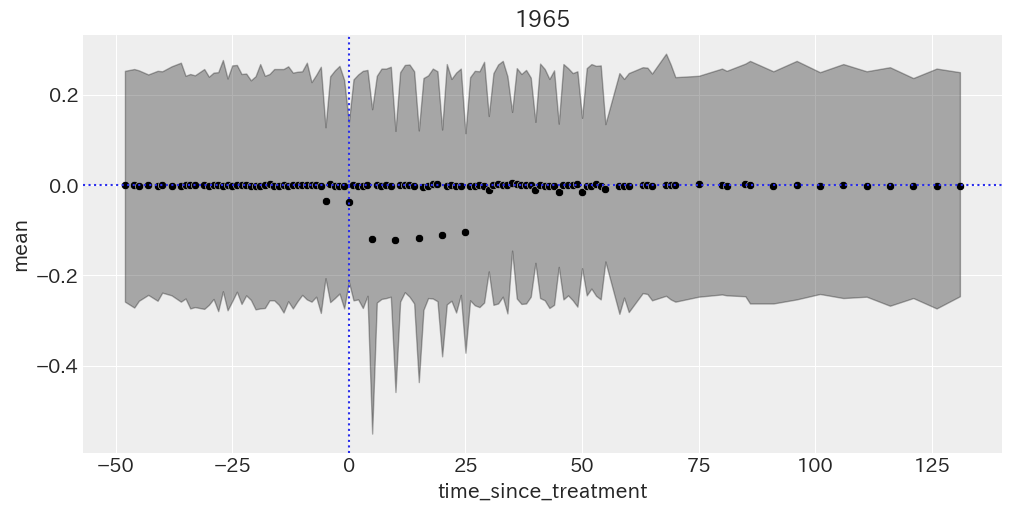

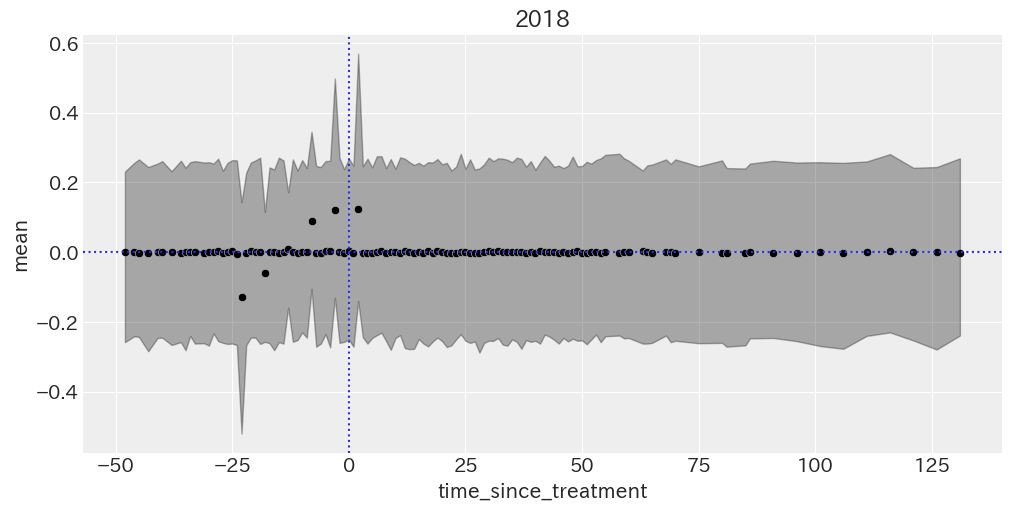

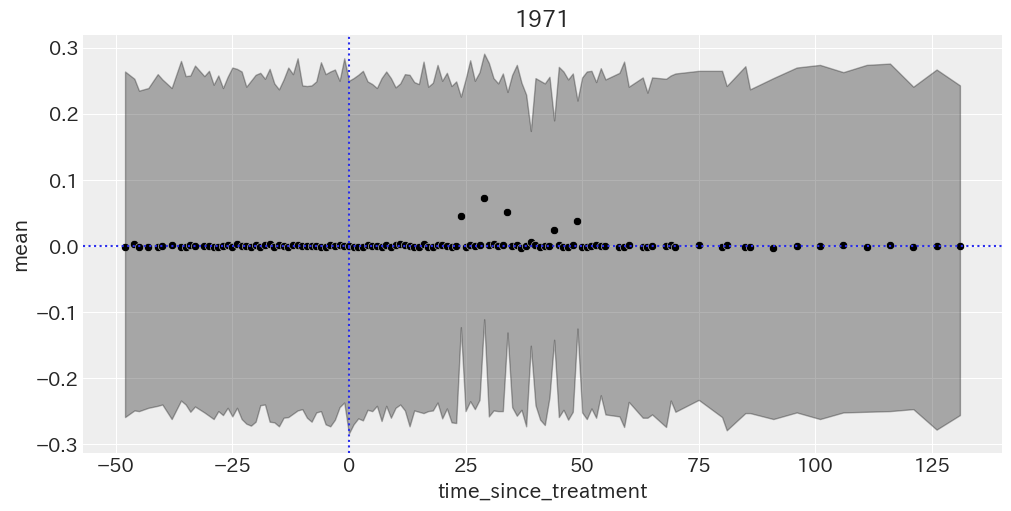

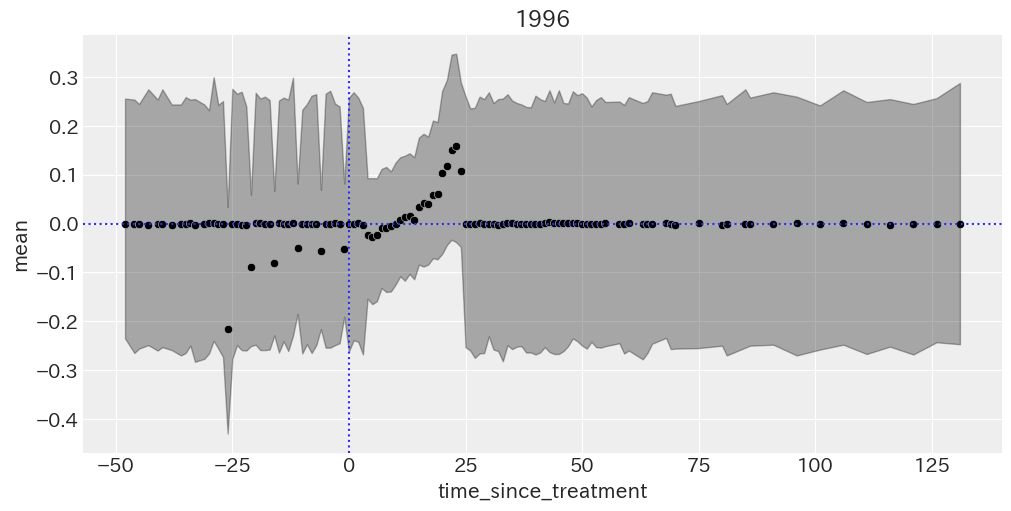

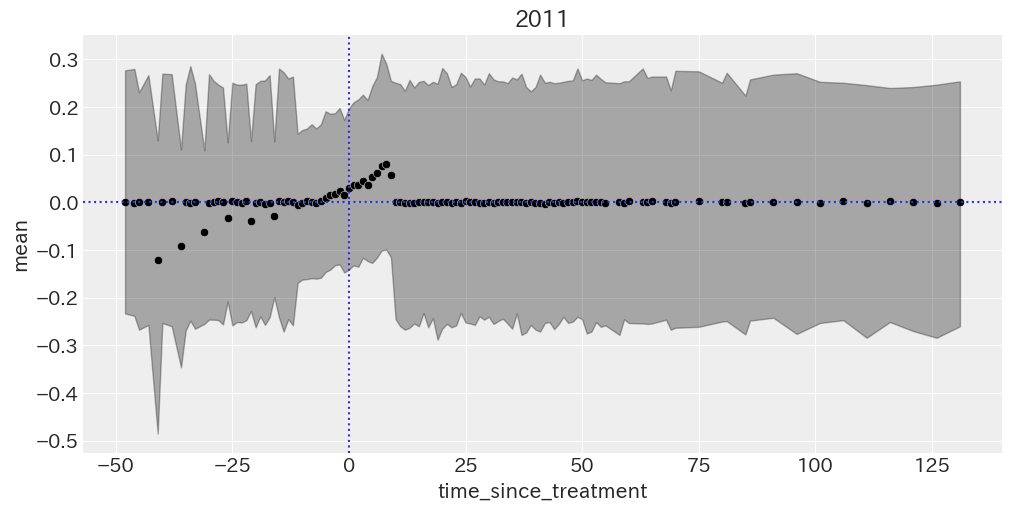

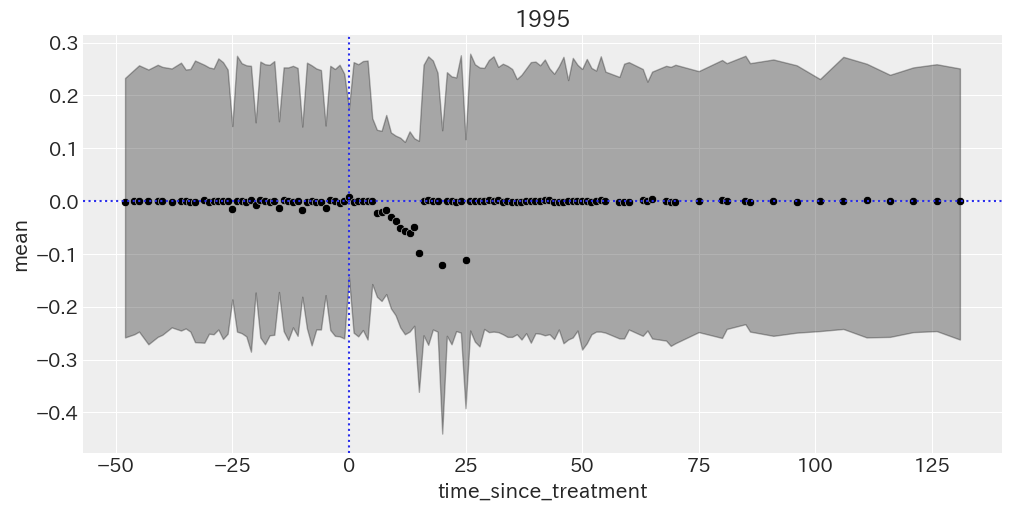

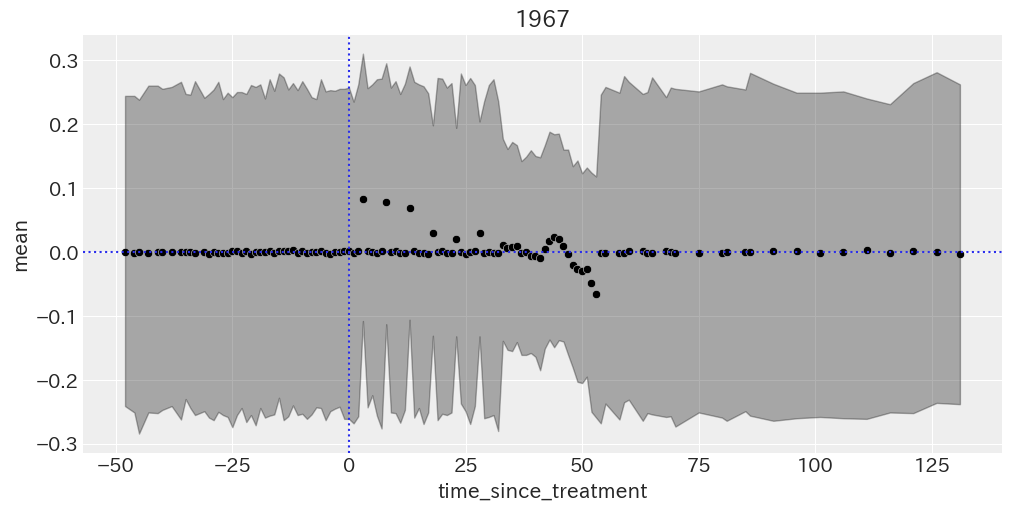

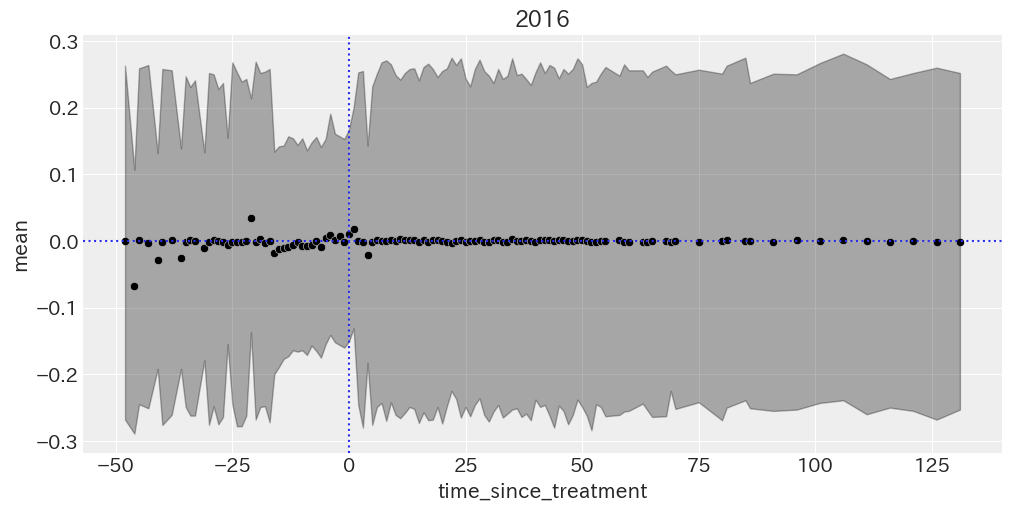

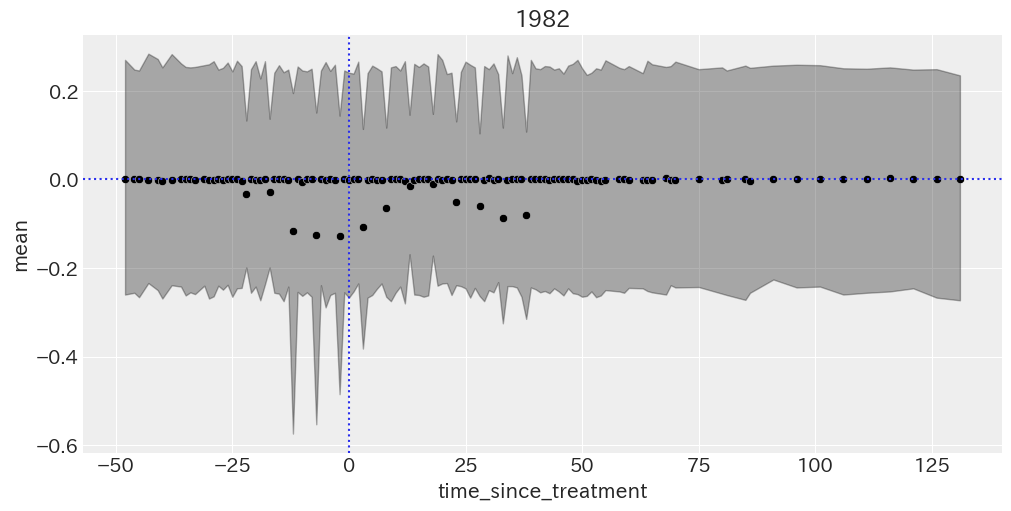

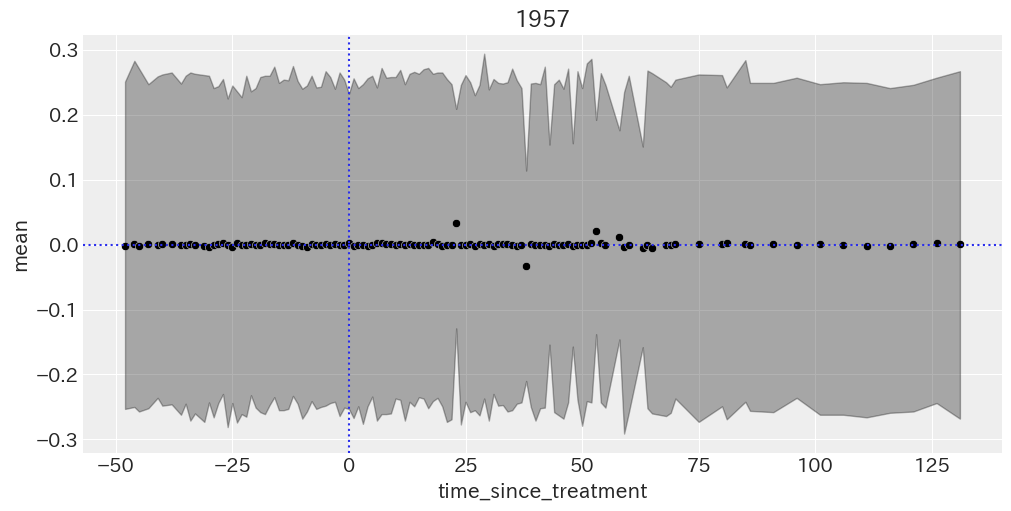

In [23]:
for bridge_year in beta_df['bridge_year'].unique():
    beta_g = beta_df[beta_df['bridge_year'] == bridge_year].sort_values('time_since_treatment')
    plt.figure(figsize=figsize)
    sns.scatterplot(x='time_since_treatment', y='mean', data=beta_g, color='black')
    plt.fill_between(
        x='time_since_treatment',
        y1='hdi_97.5%',
        y2='hdi_2.5%',
        data=beta_g,
        alpha=0.3,
        color='black'
    )
    plt.axhline(y=0, linestyle=':')
    plt.axvline(x=0, linestyle=':')
    plt.title(f'{bridge_year}')

## サンプリングの保存

In [ ]:
az.to_netcdf(trace_h_hetero, './mcmc_sample/fully_saturated/trace_h_hetero.nc')
# az.to_netcdf(trace_h_homo, './mcmc_sample/fully_saturated/trace_h_homo.nc')

In [ ]:
trace_h_hetero = az.from_netcdf('./mcmc_sample/fully_saturated/hie_hetero.nc')